# Decision Trees for Big Data Analytics

*Wannes Meert, Hendrik Blockeel, KU Leuven, 2023*

Examples based on [KU Leuven course Machine Learning and Inductive Inference (Hendrik Blockeel)](https://onderwijsaanbod.kuleuven.be/syllabi/e/H02C1AE.htm#activetab=doelstellingen_idp50160), [scikit-learn documentation](https://scikit-learn.org/stable/index.html) and [pandas documentation](http://pandas.pydata.org).

## Part 4: Inspecting Tree Ensembles

### Setup

In [ ]:
!pip install lime
!pip install shap
!pip install xgboost
!pip install dtai-veritas

In [5]:
import numpy as np
import pandas as pd
import time
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [2]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Feature importance

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.datasets import load_digits
data = load_digits(n_class=10)
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=10)

In [5]:
clf = RandomForestClassifier(n_estimators=10, max_depth=5)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=10)

In [6]:
clf.feature_importances_

array([0.        , 0.00137369, 0.01019444, 0.00872769, 0.00286675,
       0.00347001, 0.00849354, 0.        , 0.        , 0.01484813,
       0.03348154, 0.00047024, 0.        , 0.02251287, 0.00072928,
       0.        , 0.        , 0.01072303, 0.01424804, 0.02791935,
       0.00898116, 0.04985326, 0.02182835, 0.        , 0.        ,
       0.00952345, 0.07474646, 0.02823026, 0.03019003, 0.01025153,
       0.01536878, 0.        , 0.        , 0.03886347, 0.0361563 ,
       0.00512287, 0.08798451, 0.02225973, 0.02651148, 0.        ,
       0.        , 0.01283449, 0.04173767, 0.05845493, 0.01256537,
       0.02344396, 0.00094243, 0.        , 0.        , 0.0010674 ,
       0.02287041, 0.01735072, 0.00593179, 0.03941268, 0.03836164,
       0.        , 0.        , 0.        , 0.02085368, 0.00241797,
       0.02229586, 0.03336093, 0.02016784, 0.        ])

Get the most important feature:

In [7]:
np.argmax(clf.feature_importances_)

36

Or the top k most important features:

In [8]:
k = 4
topk = np.argsort(clf.feature_importances_)[-k:]
topk

array([21, 43, 26, 36])

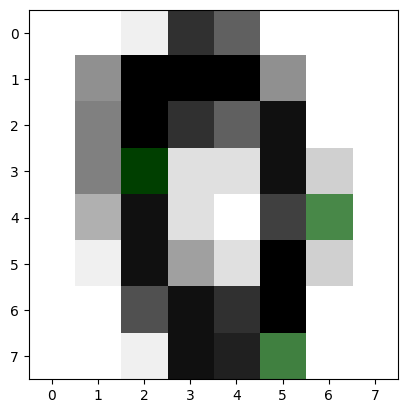

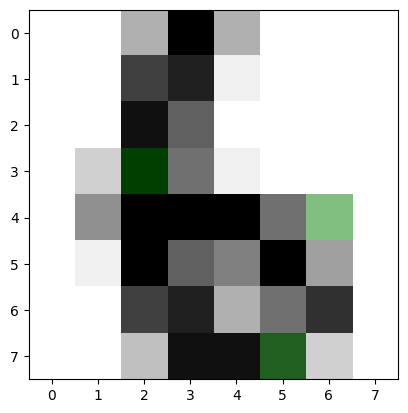

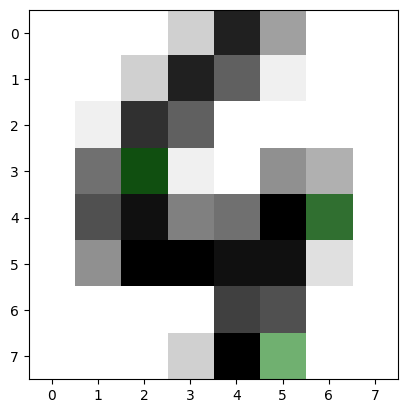

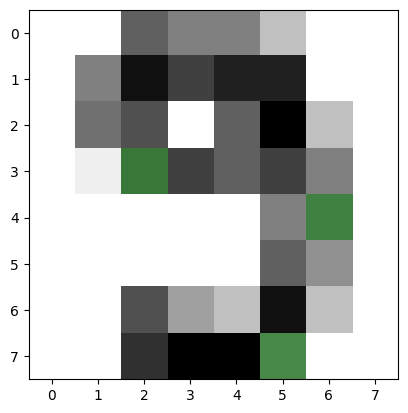

In [96]:
idxs = [1, 5, 6, 16]
for idx in idxs:
    plt.figure()
    plt.gray()
    plt.imshow(-X_train[idx].reshape(8,-1));
    # Indicate k most important features
    topk_mask = np.zeros((8,8))
    topk_mask[topk // 8, topk % 8] = 1
    cmap = matplotlib.colors.ListedColormap(['none', 'green'])
    plt.imshow(topk_mask, cmap=cmap, alpha=0.5);

### LIME

In [10]:
import lime
import lime.lime_tabular

In [11]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, discretize_continuous=True)

For a multi-class classification problem, set the top_labels parameter to only explain the top class. Since LIME expects a probabilistic classifier, we use the `predict_proba` function from scikit-learn instead of `predict`.

Expected class = 5


AttributeError: 'Tree' object has no attribute 'explain_instance'

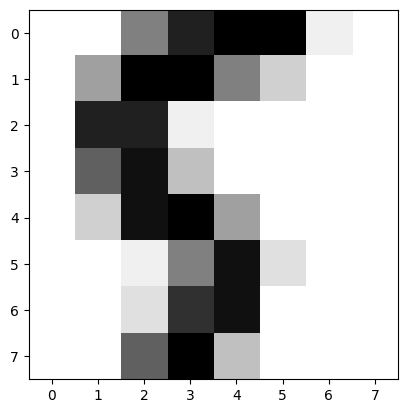

In [97]:
# i = np.random.randint(0, X_test.shape[0])
i = 0
print(f'Expected class = {y_test[i]}')
plt.imshow(-X_test[i].reshape(8,-1));
exp = explainer.explain_instance(X_test[i], clf.predict_proba, num_features=9, top_labels=2)
exp.show_in_notebook(show_table=True, show_all=False)

For more examples of LIME, see the documentation on https://github.com/marcotcr/lime .

When dealing with images, we are typically not interested in individual pixels but in regions of features. For this, LIME supports the use of 'superpixels', pixels that are connected after segmenting the figure: https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20MNIST%20and%20RF.ipynb

### SHAP

In [64]:
import shap
from shap import waterfall_plot

In [27]:
explainer = shap.TreeExplainer(clf)

In [51]:
sv = np.array(explainer.shap_values(X_test))
ev = np.array(explainer.expected_value) 

[[0.05869837 0.06680381 0.00524927 0.0115738  0.13278804 0.48817294
  0.01336323 0.14172553 0.04846902 0.033156  ]]


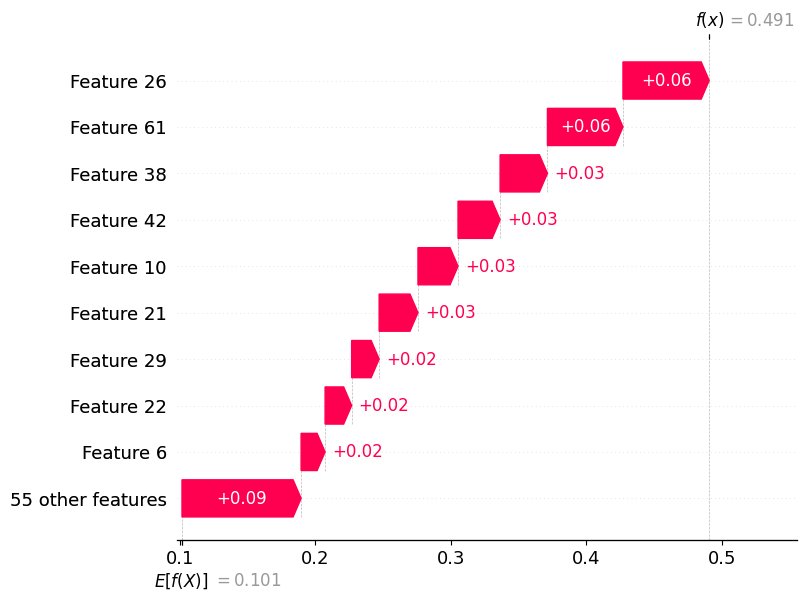

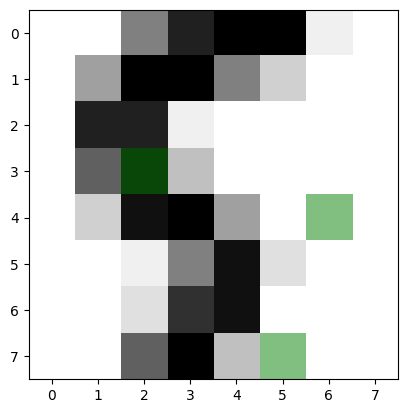

In [95]:
i = 0
print(clf.predict_proba(np.atleast_2d(X_test[idx])))
waterfall_plot(shap.Explanation(sv[5][i], ev[i]))

topk = np.array([26, 61, 38])
plt.figure()
plt.gray()
plt.imshow(-X_test[i].reshape(8,-1));
# Indicate k most important features
topk_mask = np.zeros((8,8))
topk_mask[topk // 8, topk % 8] = 1
cmap = matplotlib.colors.ListedColormap(['none', 'green'])
plt.imshow(topk_mask, cmap=cmap, alpha=0.5);

Expected class = 5


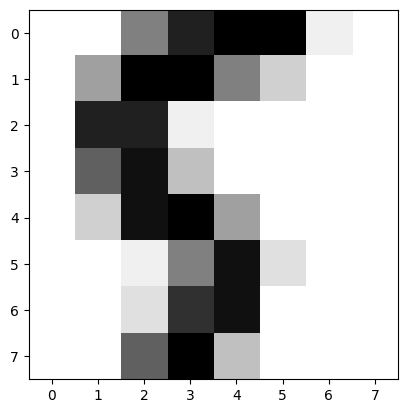

In [98]:
print(f'Expected class = {y_test[i]}')
plt.imshow(-X_test[i].reshape(8,-1));
shap_values = explainer.shap_values(np.atleast_2d(X_test[i]))
shap.initjs()
shap.force_plot(explainer.expected_value[5], shap_values[5], np.atleast_2d(X_test[i]))

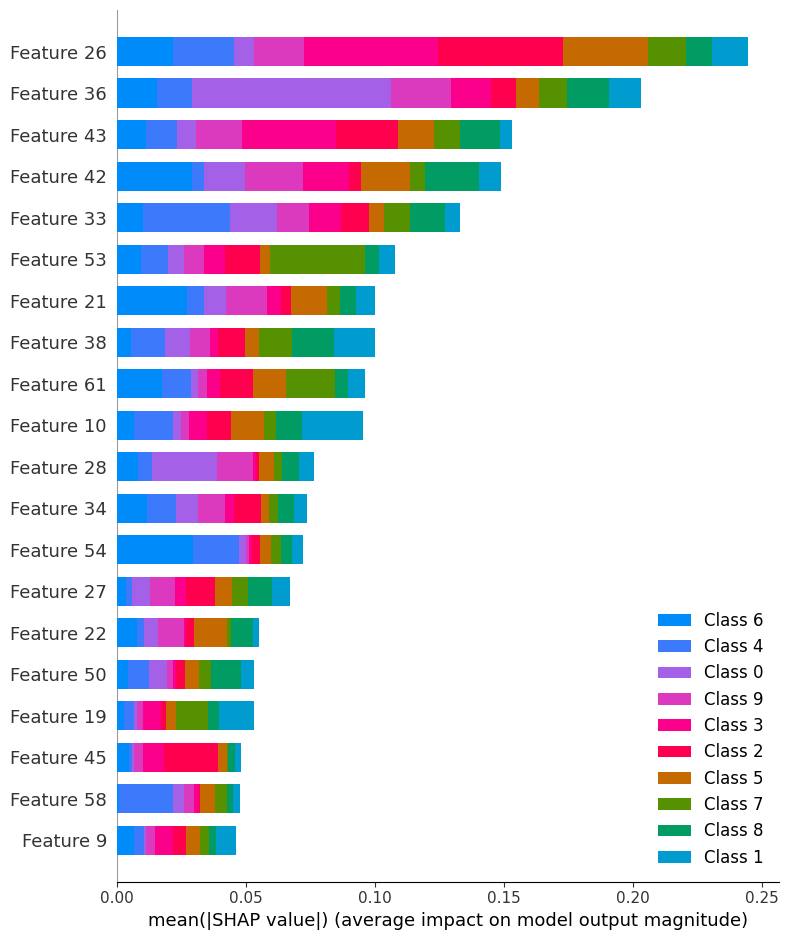

In [47]:
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

In [33]:
# shap_interaction_values = explainer.shap_interaction_values(X_test)
# shap_interaction_values[0]

### Veritas

In [71]:
import veritas
from veritas import VeritasRobustnessSearch

Load MNIST with more pixels:

In [6]:
X, y_mc = datasets.fetch_openml(data_id=554, return_X_y=True, as_frame=False)

/Users/wannes/Nextcloud/Documents/Events/2023/2023-KTU-BigDataSchool/KTU_BigDataSchool_Meert_Exercises/venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [7]:
y_mc = y_mc.astype(int)
# make it a binary classification problem for the sake of simplicity
y = y_mc >= 5
xtrain, xtest, ytrain, ytest, ytrain_mc, ytest_mc = train_test_split(X, y, y_mc, test_size=0.2, shuffle=True)

Train an XGBoost model

In [8]:
import veritas
import xgboost as xgb
import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [9]:
params = {
    "n_estimators": 50,
    #"num_class": 10,
    #"objective": "multi:softmax",
    #"eval_metric": "merror",
    "eval_metric": "error",
    
    "tree_method": "hist",
    "seed": 135,
    "max_depth": 7,
    "learning_rate": 0.2,
    "colsample_bynode": 0.75,
    "subsample": 0.5
}
model = xgb.XGBClassifier(**params)

t = time.time()
model.fit(X, y)
print(f"XGB trained in {time.time()-t} seconds")

XGB trained in 6.212253093719482 seconds


In [10]:
ytrain_pred = model.predict(xtrain)
ytest_pred = model.predict(xtest)
acc_train = accuracy_score(ytrain, ytrain_pred)
acc_test = accuracy_score(ytest, ytest_pred)

print(f"Train acc: {acc_train:.3f}, test acc: {acc_test:.3f} wrt true labels")

Train acc: 0.982, test acc: 0.983 wrt true labels


Generate adversarial examples


In [11]:
# FROM CLASS 0 -> CLASS 1
number_of_adv_examples = 5

rng = np.random.default_rng(seed=128)
xtest0 = xtest[ytest==0, :]
subset = xtest0[rng.choice(range(xtest0.shape[0]), number_of_adv_examples), :]

eps = 10

In [12]:
feat2id = lambda s: int(s[1:])
at = veritas.addtree_from_xgb_model(model, feat2id)

In [13]:
adv_examples = []
for i in tqdm.tqdm(range(subset.shape[0])):
    base_example = subset[i, :]
    
    s = veritas.Search.max_output(at)
    s.prune([veritas.Domain(max(0.0, x-eps), min(255, x+eps)) for x in base_example])
    s.stop_when_upper_less_than = 0.0

    tstart = time.time()
    while s.num_solutions() == 0:
        if s.steps(100) == veritas.StopReason.NO_MORE_OPEN:
            break
    tstop = time.time()

    if s.num_solutions() > 0:
        sol = s.get_solution(0)
        adv_example = veritas.get_closest_example(sol, base_example)

        res = {"i": i, "adv_example": adv_example, "base_example": base_example}

        res["base_ypred_at"] = at.predict_proba(np.atleast_2d(base_example))[0]
        res["base_ypred"] = model.predict_proba(np.atleast_2d(base_example))[0,1]
        res["adv_ypred"] = model.predict_proba(np.atleast_2d(adv_example))[0,1]
        res["adv_ypred_at"] = at.predict_proba(np.atleast_2d(adv_example))[0]

        adv_examples.append(res)
    else:
        print("no adversarial examples found for", i)

100%|██████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 52.93it/s]


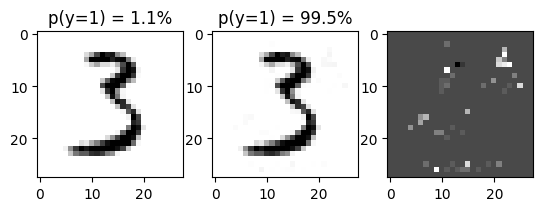

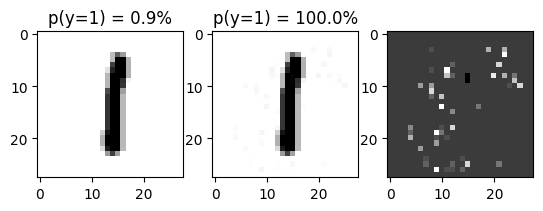

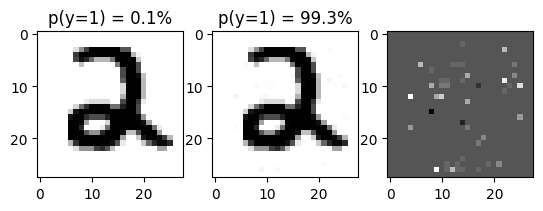

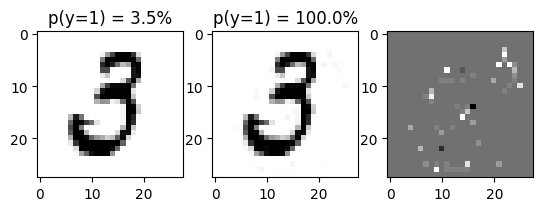

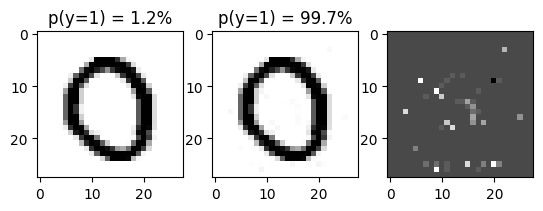

In [14]:
for i, res in enumerate(adv_examples):
    base_example = res["base_example"]
    adv_example = res["adv_example"]
    base_prob = res["base_ypred"]
    adv_prob = res["adv_ypred"]
    
    fig, ax = plt.subplots(1, 3)
    ax[0].imshow((base_example).reshape((28,28)), cmap="binary")
    ax[0].set_title(f"p(y=1) = {base_prob*100:.1f}%")
    ax[1].imshow((adv_example).reshape((28,28)), cmap="binary")
    ax[1].set_title(f"p(y=1) = {adv_prob*100:.1f}%")
    ax[2].imshow((adv_example-base_example).reshape((28,28)))
    
    plt.show()